In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import numpy as np
import math
import pandas as pd
import string 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the dataset
file_path = '/kaggle/input/anlp-assignment-2/train.csv'

dataset = pd.read_csv(file_path)

In [37]:
# Load the dataset
file_path = '/kaggle/input/anlp-assignment-2/train.csv'

dataset = pd.read_csv(file_path)

In [3]:
dataset.head()

,Class Index,Description
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [4]:
# Define a set of common English stopwords
manual_stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
    "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
    "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "d", "ll", "m", "o", "re", "ve", "y",
    "ain", "aren", "couldn", "didn", "doesn", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan",
    "shouldn", "wasn", "weren", "won", "wouldn"
])


In [5]:
def simple_preprocess_text(text):
    tokens = text.split()
    tokens = [word.lower().strip(string.punctuation) for word in tokens if word.isalpha() and word.lower() not in manual_stopwords]
    return tokens

dataset['Processed_Description'] = dataset['Description'].apply(simple_preprocess_text)

In [38]:
dataset_test['Processed_Description'] = dataset_test['Description'].apply(simple_preprocess_text)

In [40]:
dataset_test['Processed_Description']

0       [unions, representing, workers, turner, newall...
1       [canada, rocketeers, competing, million, ansar...
2       [ap, company, founded, chemistry, researcher, ...
3       [ap, barely, dawn, mike, fitzpatrick, starts, ...
4       [ap, southern, agency, went, emissions, bovine...
                              ...                        
7595    [ukrainian, presidential, candidate, viktor, y...
7596    [supply, attractive, pitching, options, dwindl...
7597    [like, roger, clemens, almost, exactly, eight,...
7598    [singapore, doctors, united, states, warned, p...
7599    [ebay, plans, buy, apartment, home, rental, se...
Name: Processed_Description, Length: 7600, dtype: object

In [6]:
dataset['Processed_Description']

0                            [reuters, wall, seeing, green]
1         [reuters, private, investment, firm, carlyle, ...
2         [reuters, soaring, crude, prices, plus, econom...
3         [reuters, authorities, halted, oil, main, pipe...
4         [afp, tearaway, world, oil, toppling, records,...
                                ...                        
119995    [karachi, pakistani, president, pervez, mushar...
119996    [red, sox, general, manager, theo, epstein, ac...
119997    [miami, dolphins, put, courtship, lsu, coach, ...
119998    [pittsburgh, ny, giants, steelers, steelers, g...
119999    [indianapolis, vince, carter, traded, toronto,...
Name: Processed_Description, Length: 120000, dtype: object

In [7]:
# Build vocabulary
word_counter = Counter()
for tokens in dataset['Processed_Description']:
    word_counter.update(tokens)


In [42]:
#build vocabulary test
word_counter_test = Counter()
for tokens in dataset_test['Processed_Description']:
    word_counter_test.update(tokens)


In [43]:
# for test
vocab_size = len(word_counter_test)
word_to_idx_test = {word: idx for idx, (word, _) in enumerate(word_counter_test.most_common())}
idx_to_word_test = {idx: word for word, idx in word_to_idx_test.items()}



In [8]:
# for train
vocab_size = len(word_counter)
word_to_idx = {word: idx for idx, (word, _) in enumerate(word_counter.most_common())}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}


In [9]:
# Convert words to indices
dataset['Description_Idx'] = dataset['Processed_Description'].apply(lambda x: [word_to_idx[word] for word in x])

In [48]:
# Convert words to indices for test 
dataset_test['Description_Idx'] = dataset_test['Processed_Description'].apply(lambda x: [word_to_idx_test[word] for word in x])

In [49]:
dataset_test['Description_Idx']

0       [1541, 2240, 231, 3808, 6690, 120, 108, 9269, ...
1       [613, 9270, 2648, 21, 2649, 1368, 2241, 9271, ...
2       [5, 9, 4422, 6692, 2974, 494, 2650, 2975, 813,...
3       [5, 1765, 6694, 668, 9273, 1060, 2063, 9274, 6...
4       [5, 257, 275, 509, 2651, 9276, 3809, 6699, 4, ...
                              ...                        
7595    [2959, 171, 1413, 3758, 6331, 9078, 6385, 682,...
7596    [611, 4674, 3247, 2858, 6729, 1130, 506, 1078,...
7597    [156, 1573, 3061, 357, 2624, 438, 37, 1078, 11...
7598    [595, 1468, 15, 74, 321, 16835, 6472, 3776, 32...
7599    [1888, 51, 195, 4802, 99, 3313, 88, 1225, 266,...
Name: Description_Idx, Length: 7600, dtype: object

In [10]:
dataset['Description_Idx']

0                                      [19, 249, 2890, 595]
1         [19, 632, 527, 242, 15157, 3491, 325, 2579, 38...
2         [19, 1697, 287, 36, 3538, 367, 928, 197, 126, ...
3         [19, 506, 4546, 15, 502, 2749, 294, 51, 412, 7...
4         [99, 33238, 8, 15, 7732, 1770, 10954, 3063, 0,...
                                ...                        
119995    [7096, 1141, 11, 1621, 1737, 1, 1065, 341, 159...
119996    [123, 258, 155, 330, 4362, 9621, 3073, 6825, 9...
119997    [639, 1489, 240, 13378, 3977, 122, 2786, 7559,...
119998    [1192, 2789, 582, 2479, 2479, 582, 2479, 582, ...
119999    [1696, 3666, 2570, 1892, 451, 3263, 0, 2091, 2...
Name: Description_Idx, Length: 120000, dtype: object

In [11]:
max_index = max(max(sentence) if sentence else 0 for sentence in dataset['Description_Idx'])


In [12]:
vocab_size = max_index + 1

print(vocab_size)

50201


In [13]:
# Adjust the labels in the 'Class Index' column
dataset['Class Index'] = dataset['Class Index'] - 1

# Now split the dataset and create the DataLoader


In [14]:
num_classes = len(dataset['Class Index'].unique())
# elmo_model = ELMo(vocab_size, embedding_dim, hidden_dim, num_classes)


In [15]:
num_classes

4

In [50]:
dataset_test['Class Index'] = dataset_test['Class Index'] - 1

In [17]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(ELMo, self).__init__()
        
        hidden_dim = embedding_dim // 2  # Half of embedding_dim for bidirectional LSTM
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(2 * hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)
        
        # Define the scalar mixing parameters
        self.s = nn.Parameter(torch.ones(3))
        self.gamma = nn.Parameter(torch.ones(1))
        
    def forward(self, x):
        embeds = self.embedding(x)
        lstm1_out, _ = self.lstm1(embeds)
        lstm2_out, _ = self.lstm2(lstm1_out)
        weighted_sum = self.gamma * (self.s[0] * embeds + self.s[1] * lstm1_out + self.s[2] * lstm2_out)
        output = self.fc(weighted_sum[:, -1, :])
        return output


In [18]:
# Initialize the ELMo model
embedding_dim = 300
hidden_dim = 256
num_classes
# vocab_size = 12000
elmo_model = ELMo(vocab_size, embedding_dim, num_classes)

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(elmo_model.parameters(), lr=0.001)

In [22]:


from torch.utils.data import Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {'input': torch.tensor(self.texts[idx], dtype=torch.long), 'target': torch.tensor(self.labels[idx], dtype=torch.long)}

In [24]:
# Create DataLoader for training and validation
from torch.utils.data import random_split

# The rest of your code remains unchanged
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Convert the Subset objects back to DataFrames
train_df = dataset.iloc[train_dataset.indices]
val_df = dataset.iloc[val_dataset.indices]

# Create DataLoader objects using the TextDataset class
train_loader = DataLoader(TextDataset(train_df['Description_Idx'].tolist(), train_df['Class Index'].tolist()), batch_size=32, shuffle=True)
val_loader = DataLoader(TextDataset(val_df['Description_Idx'].tolist(), val_df['Class Index'].tolist()), batch_size=32, shuffle=False)


In [52]:
test_loader = DataLoader(TextDataset(dataset_test['Description_Idx'].tolist(), dataset_test['Class Index'].tolist()), batch_size=32, shuffle=False)

In [25]:
from torch.nn.utils.rnn import pad_sequence

# Define a custom collate function
def collate_batch(batch):
    # Separate the input sequences and target labels from the batch
    inputs = [item['input'] for item in batch]
    targets = [item['target'] for item in batch]

    # Pad the input sequences to the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)

    # Convert the target labels to a tensor
    targets = torch.tensor(targets, dtype=torch.long)

    return {'input': inputs_padded, 'target': targets}

# Create DataLoader objects using the TextDataset class and the custom collate function
train_loader = DataLoader(TextDataset(train_df['Description_Idx'].tolist(), train_df['Class Index'].tolist()), batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(TextDataset(val_df['Description_Idx'].tolist(), val_df['Class Index'].tolist()), batch_size=32, shuffle=False, collate_fn=collate_batch)



In [53]:
test_loader = DataLoader(TextDataset(dataset_test['Description_Idx'].tolist(), dataset_test['Class Index'].tolist()), batch_size=32, shuffle=False, collate_fn=collate_batch)


In [26]:
# # Training Loop for Pretraining
# num_epochs = 5
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         optimizer.zero_grad()
#         outputs = elmo_model(batch['input'])
#         loss = criterion(outputs, batch['target'])
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [27]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU
elmo_model.to(device)

# Training Loop for Pretraining
num_epochs = 5
for epoch in range(num_epochs):
    for batch in train_loader:
        # Move the input and target to GPU
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = elmo_model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.39377760887145996
Epoch 2, Loss: 0.1983366459608078
Epoch 3, Loss: 0.36936119198799133
Epoch 4, Loss: 0.47133225202560425
Epoch 5, Loss: 0.08546923846006393


In [30]:
# Training Loop for Downstream Task
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = elmo_model(batch['input'].to(device))
        loss = criterion(outputs, batch['target'].to(device))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.04857121407985687
Epoch 2, Loss: 0.18727345764636993
Epoch 3, Loss: 0.02423313818871975
Epoch 4, Loss: 0.14702728390693665
Epoch 5, Loss: 0.024045903235673904


In [33]:
# Evaluate the model on the validation set
elmo_model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        outputs = elmo_model(inputs)  # Use the variable 'inputs' here
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)  # Use the variable 'targets' here
        correct += (predicted == targets).sum().item()  # Use the variable 'targets' here

print('Accuracy of the model on the validation set: {}%'.format(100 * correct / total))


Accuracy of the model on the validation set: 87.52083333333333%


In [36]:
# Example: If you wish to add a dropout layer for regularization during fine-tuning
elmo_model.dropout = nn.Dropout(0.5)





# Continue training on the classification task
num_epochs_downstream = 5  # You can set a different number of epochs for fine-tuning
for epoch in range(num_epochs_downstream):
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = elmo_model(batch['input'].to(device))
        loss = criterion(outputs, batch['target'].to(device))
        loss.backward()
        optimizer.step()
    print(f'Downstream Task - Epoch {epoch+1}, Loss: {loss.item()}')

Downstream Task - Epoch 1, Loss: 0.0024939102586358786
Downstream Task - Epoch 2, Loss: 0.10224974900484085
Downstream Task - Epoch 3, Loss: 0.22253955900669098
Downstream Task - Epoch 4, Loss: 0.00043351511703804135
Downstream Task - Epoch 5, Loss: 0.15808668732643127


Loss Function: CrossEntropyLoss
Number of Epochs:  5
Optimizer: Adam
Accuracy:  0.25644736842105265
Micro F1 Score:  0.25644736842105265


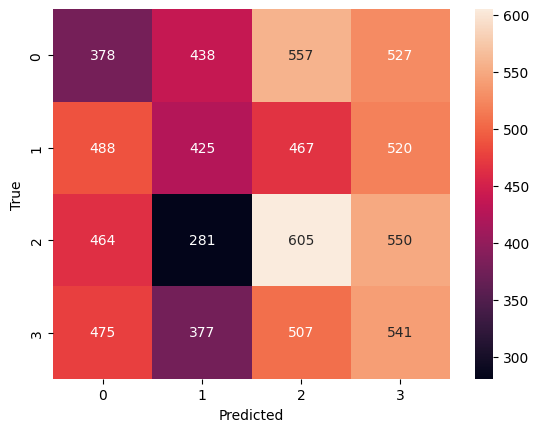

In [55]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Report Hyperparameters
print("Loss Function: CrossEntropyLoss")
print("Number of Epochs: ", num_epochs)
# print("Learning Rate: ", learning_rate)
print("Optimizer: Adam")

# Evaluate the model on the test set
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        outputs = elmo_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(all_targets, all_preds)
micro_f1 = f1_score(all_targets, all_preds, average='micro')
print("Accuracy: ", accuracy)
print("Micro F1 Score: ", micro_f1)

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# now i calculate loss and accuracuy on test set